In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('../')
from python_code import model
os.chdir('notebooks')
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [2]:
df = pd.read_csv('../../data/cheese.csv')

In [3]:
group = df.groupby('store')
stores = list(group.groups.keys())

In [4]:
X_stores = []
y_stores = []
for store in stores:
    df_store = group.get_group(store)
    X = np.ones([df_store.shape[0], 4])
    X[:, 1] = np.log(df_store['price'])
    X[:, 2] = df_store['disp'] 
    X[:, 3] = df_store['disp'] * np.log(df_store['price'])
    y = np.log(df_store['vol']).to_numpy()
    X_stores.append(X)
    y_stores.append(y)

In [5]:
mod = model.Model(X_stores, y_stores, df.shape[0], n_iter=10000)
mod.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:43<00:00, 96.94it/s]


import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("husl", 88)
g = sns.FacetGrid(df, palette=palette, row="store", hue="store", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="values", fill=True, alpha=0.6)
g.map_dataframe(sns.kdeplot, x="values", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "store")
g.fig.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], xlabel="values")
g.set(ylabel="")
g.despine(left=True)
plt.savefig('ridgeplot.png')

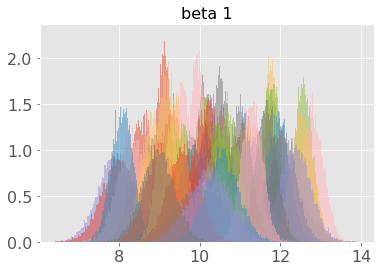

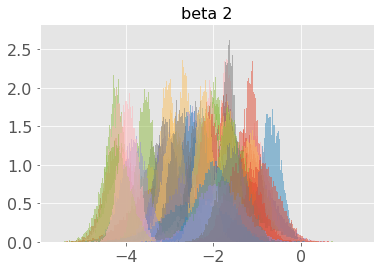

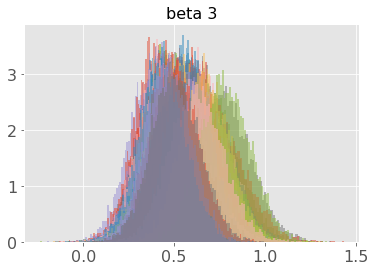

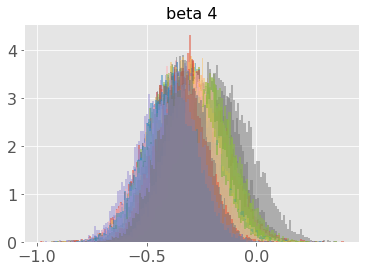

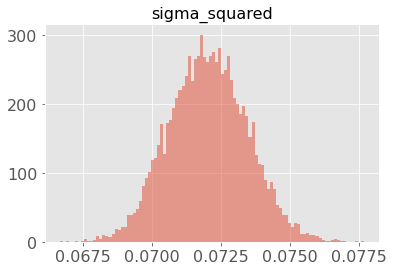

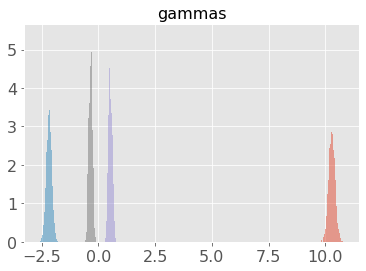

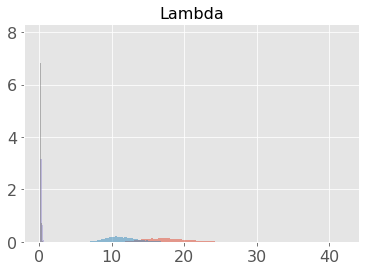

<Figure size 432x288 with 0 Axes>

In [6]:
mod.plot_all_histograms()

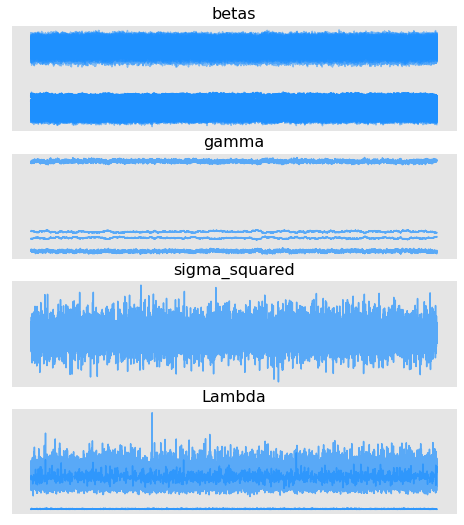

In [7]:
mod.plot_all_traces()

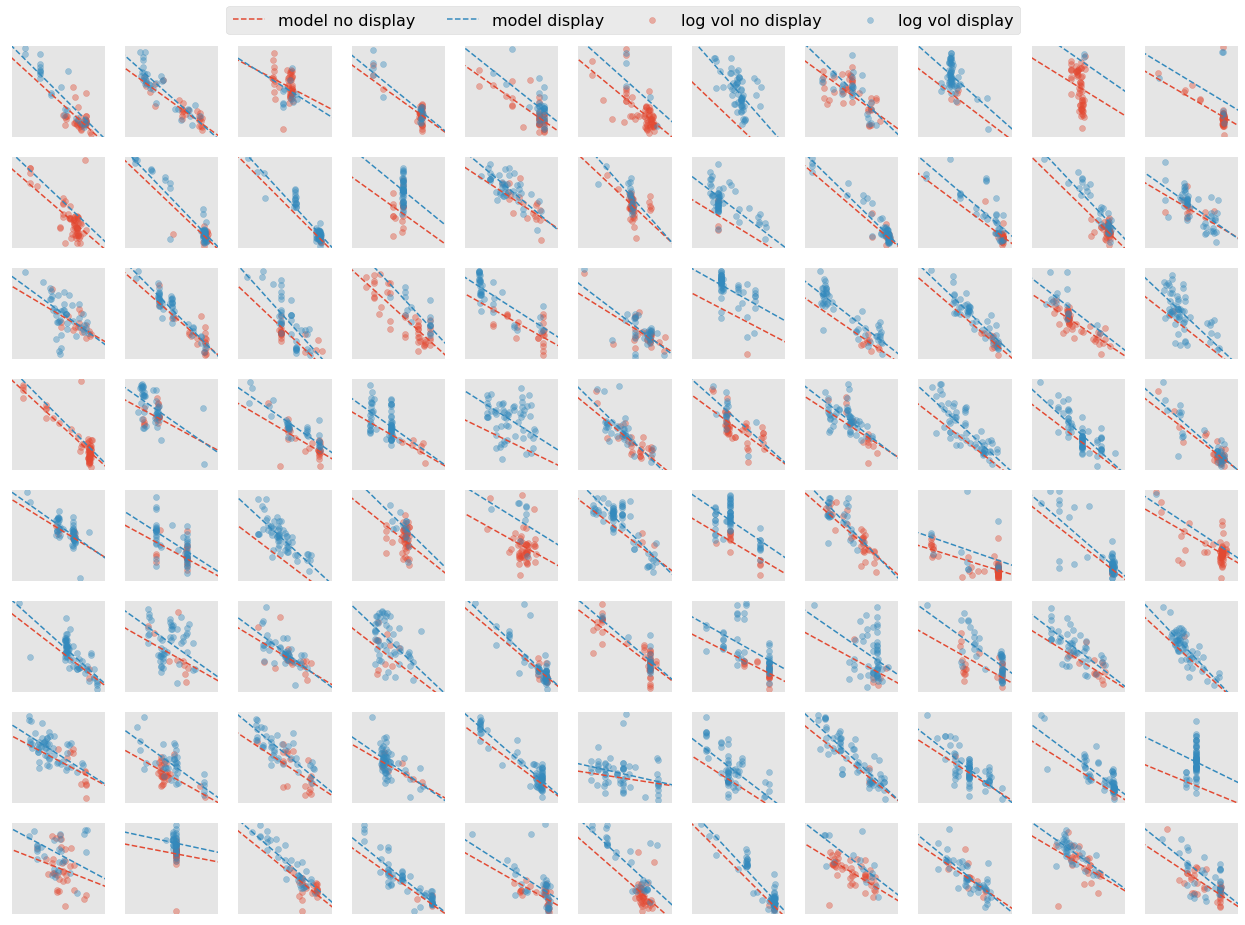

In [8]:
plt.figure(figsize=(22, 16))

for i in range(len(stores)):
    plt.subplot(8, 11, i+1)
    disp = X_stores[i][:, 2]
    plt.xticks([])
    plt.yticks([])
    plt.scatter(X_stores[i][disp == 0][:, 1], y_stores[i][disp == 0], alpha = .4, label='log vol no display')
    plt.scatter(X_stores[i][disp == 1][:, 1], y_stores[i][disp == 1], alpha = .4, label='log vol display') 
    
    betas = mod.traces['betas'].mean(axis=0)[:,i]
    X_plot = np.linspace(0,20,100)
    y_no_disp = X_plot*betas[1] + betas[0]
    y_disp = X_plot*(betas[1]+betas[3]) + betas[0] + betas[2]
    
    plt.plot(X_plot, y_no_disp, linestyle='--', label='model no display')
    plt.plot(X_plot, y_disp, linestyle='--', label='model display')
    plt.xlim(X_stores[i][:, 1].min() - 0.1 , X_stores[i][:, 1].max() + 0.1)
    plt.ylim(y_stores[i].min() - 0.1 , y_stores[i].max() + 0.1)
    if i == 0:
        plt.legend(bbox_to_anchor=(2.2,1.5),ncol=4)
plt.savefig('cheese.png',dpi=800)    

In [9]:
n_traces = 100
stores_sim_data = []
n_stores = len(stores)

for store in tqdm(range(n_stores)):
    n_points = len(X_stores[store])
    y_simulated = np.zeros([n_traces, n_points])
    for trace in range(n_traces):
        betas = mod.traces['betas'][trace,:,store]
        cov = np.identity(n_points) * mod.traces['sigma_squared'][trace]
        y_i = multivariate_normal(mean=X_stores[store]@betas, cov=cov ).rvs()
        y_simulated[trace, :] = y_i
    
    stores_sim_data.append(y_simulated)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:18<00:00,  4.72it/s]


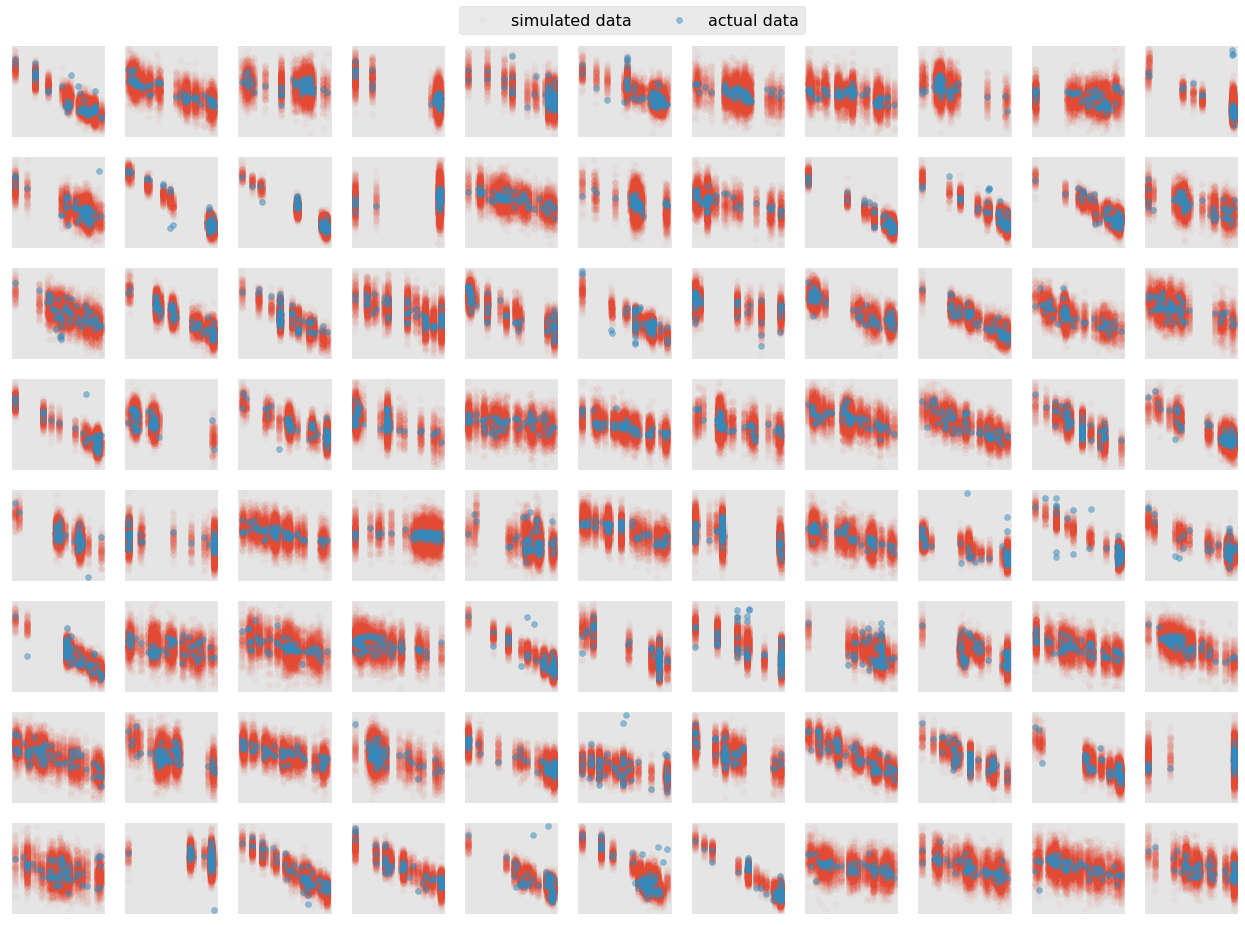

In [10]:
plt.figure(figsize=(22, 16))
for store in range(n_stores):
    plt.subplot(8, 11, store+1)
    n_points = len(X_stores[store])
    plt.scatter(np.repeat(X_stores[store][:,1], n_traces).reshape(n_points,n_traces),  stores_sim_data[store].T, alpha=.04, label='simulated data')
    plt.scatter(X_stores[store][:, 1], y_stores[store], alpha=.5, label='actual data')
    plt.xticks([])
    plt.yticks([])
    if store == 0:
        plt.legend(bbox_to_anchor=(8.5,1.5),ncol=2)

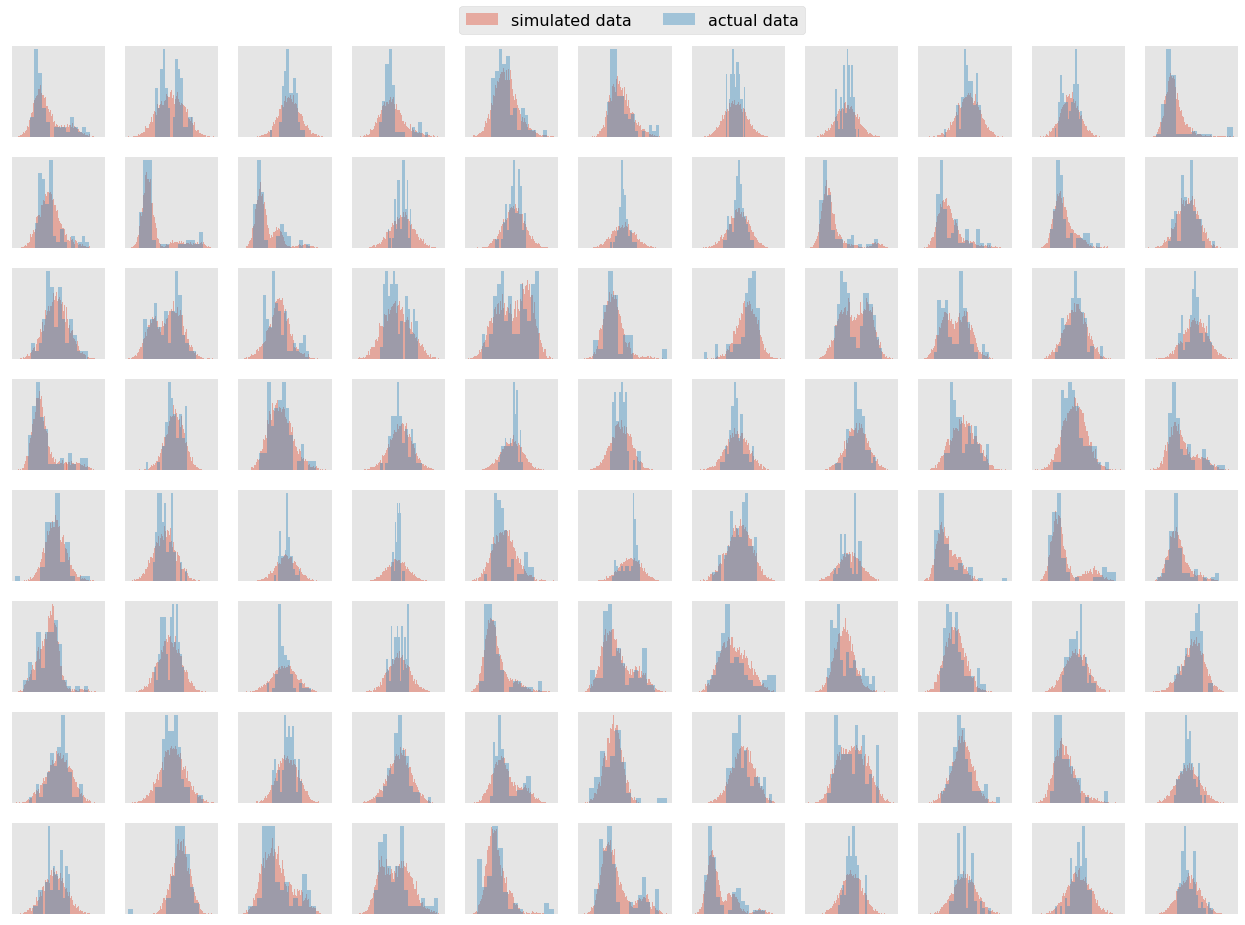

In [11]:
plt.figure(figsize=(22, 16))
for store in range(n_stores):
    plt.subplot(8, 11, store+1)
    n_points = len(X_stores[store])
    plt.hist(stores_sim_data[store].flatten(), alpha=.4, label='simulated data', density=True, bins=100)
    plt.hist(y_stores[store], alpha=.4, label='actual data', density=True, bins=15)
    plt.xticks([])
    plt.yticks([])
    if store == 0:
        plt.legend(bbox_to_anchor=(8.5,1.5),ncol=2)

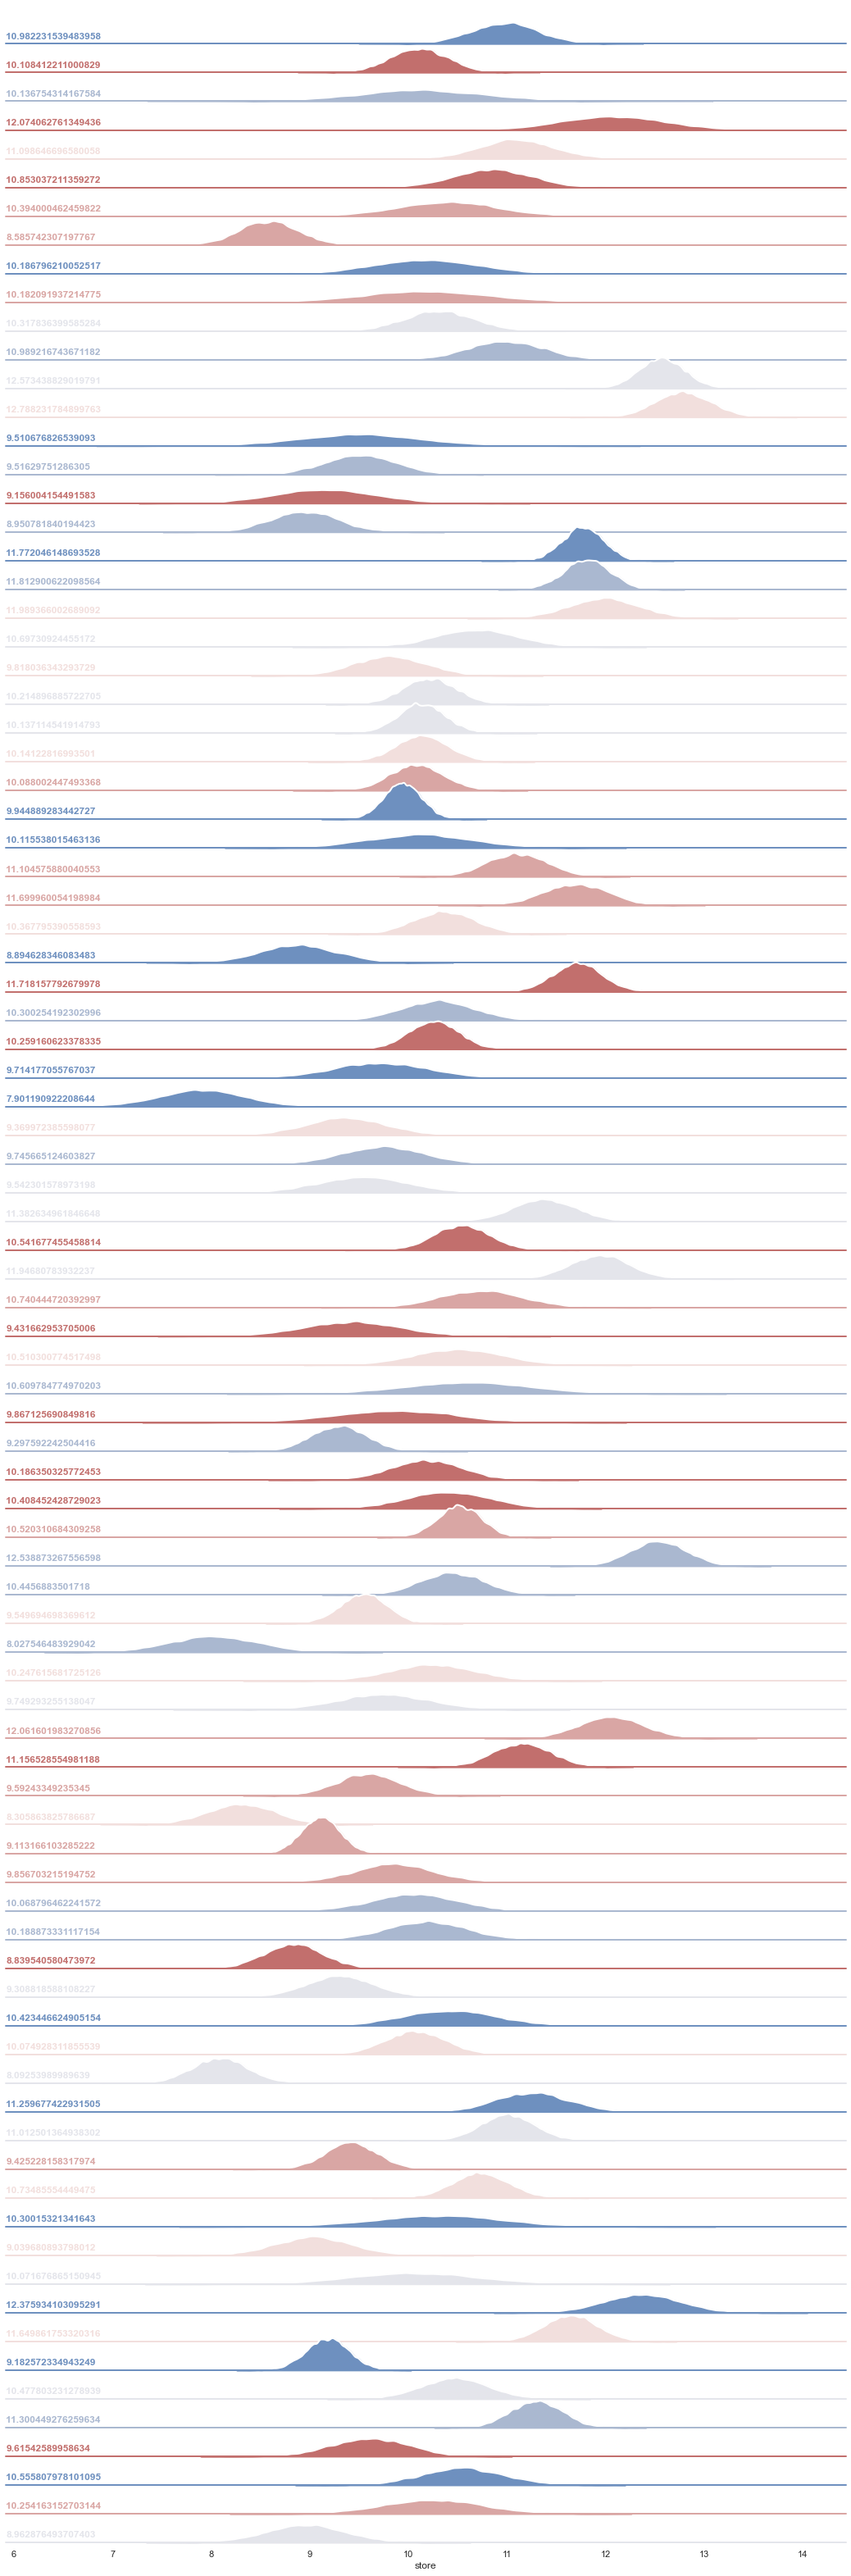

In [15]:
dfs = [pd.DataFrame(mod.traces['betas'][:,0,n]) for n in range(len(stores))]
for n in range(len(stores)):
    dfs[n]['store'] = stores[n]
    
df_new = pd.concat(dfs)
df_new.columns = ['values','store']   

mean_stores = df_new.groupby('store').mean().reset_index()
mean_stores.columns = ['store', 'mean']
df = pd.merge(df_new, mean_stores, how='inner',on='store')


import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data


# Initialize the FacetGrid object
pal = sns.color_palette('coolwarm', n_colors=88)
g = sns.FacetGrid(df, row="store", hue="mean", aspect=30, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "store")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig('beta_1_ridgeplot.png', dpi=300)

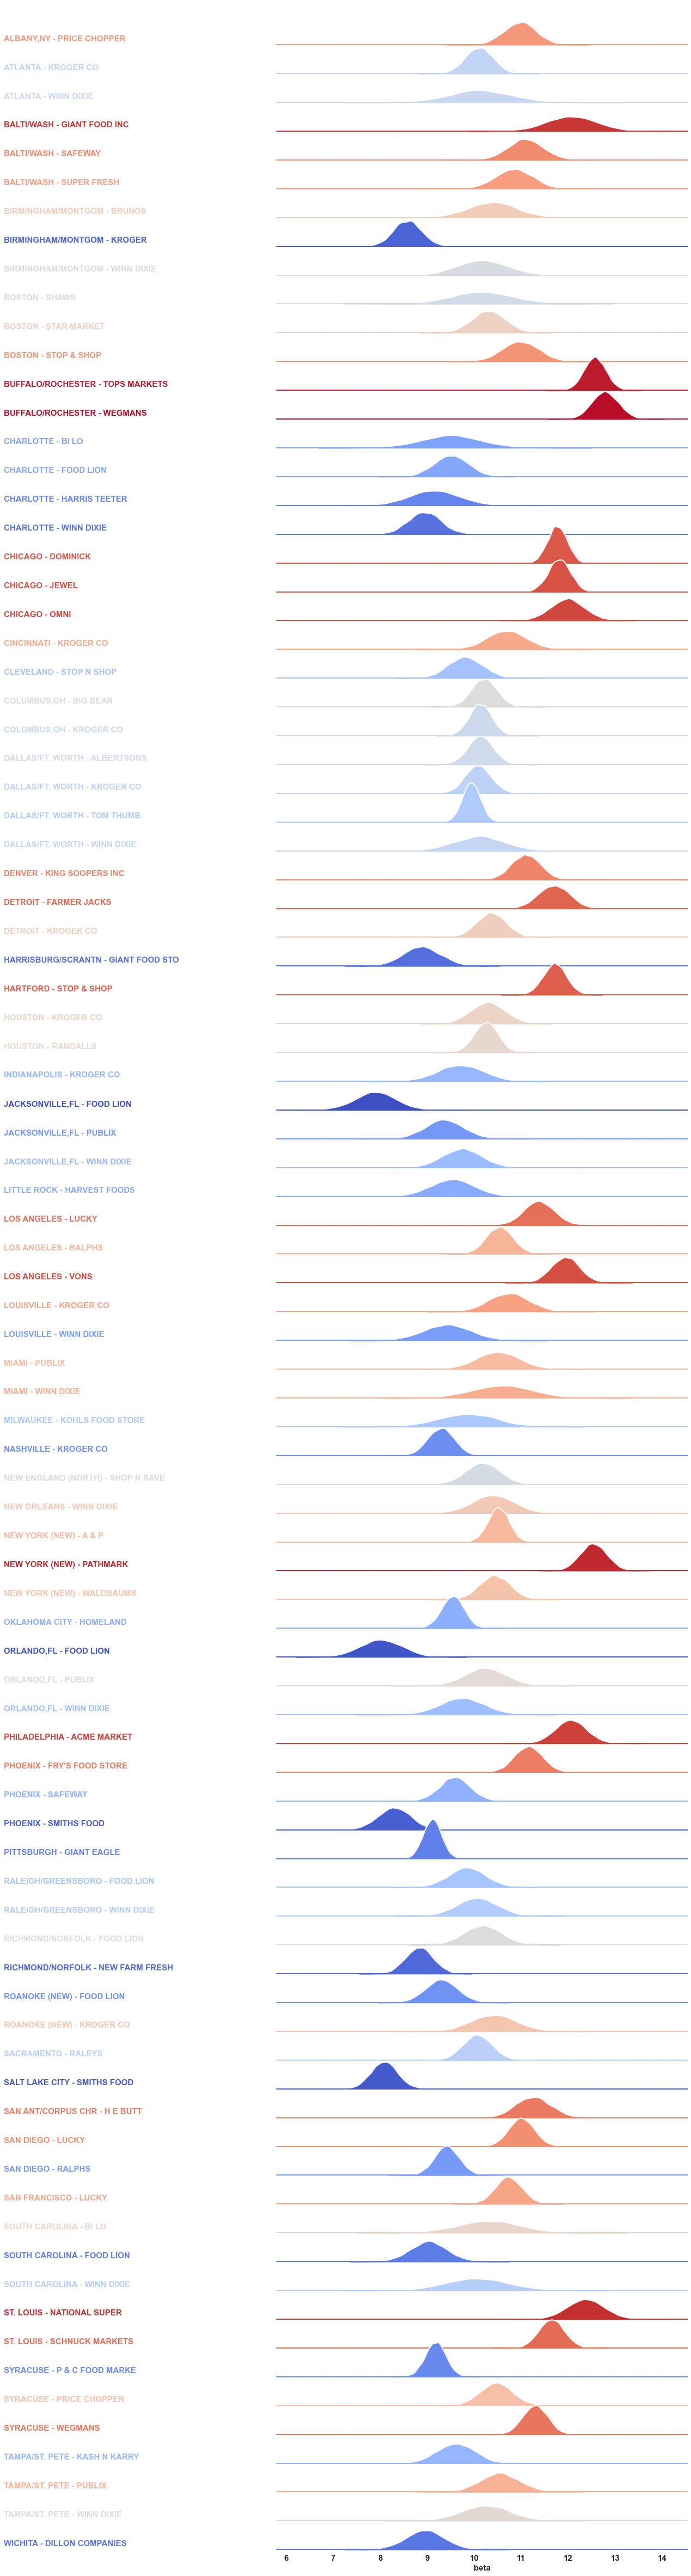

In [21]:
pal = sns.color_palette(palette='coolwarm', n_colors=88)

g = sns.FacetGrid(df, row='store', hue='mean', aspect=15, height=0.75, palette=pal)

g.map(sns.kdeplot, 'values',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, 'values', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.text(1, .2, stores[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    
g.fig.subplots_adjust(hspace=-0.3)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('beta', fontweight='bold', fontsize=15)
#g.fig.s#uptitle('beta per store',
              # ha='right',
        #       fontsize=20,
        #       fontweight=20)'
    
g.set(yticks=[], ylabel="")

plt.savefig('beta_1_ridgeplot.png', dpi=300)

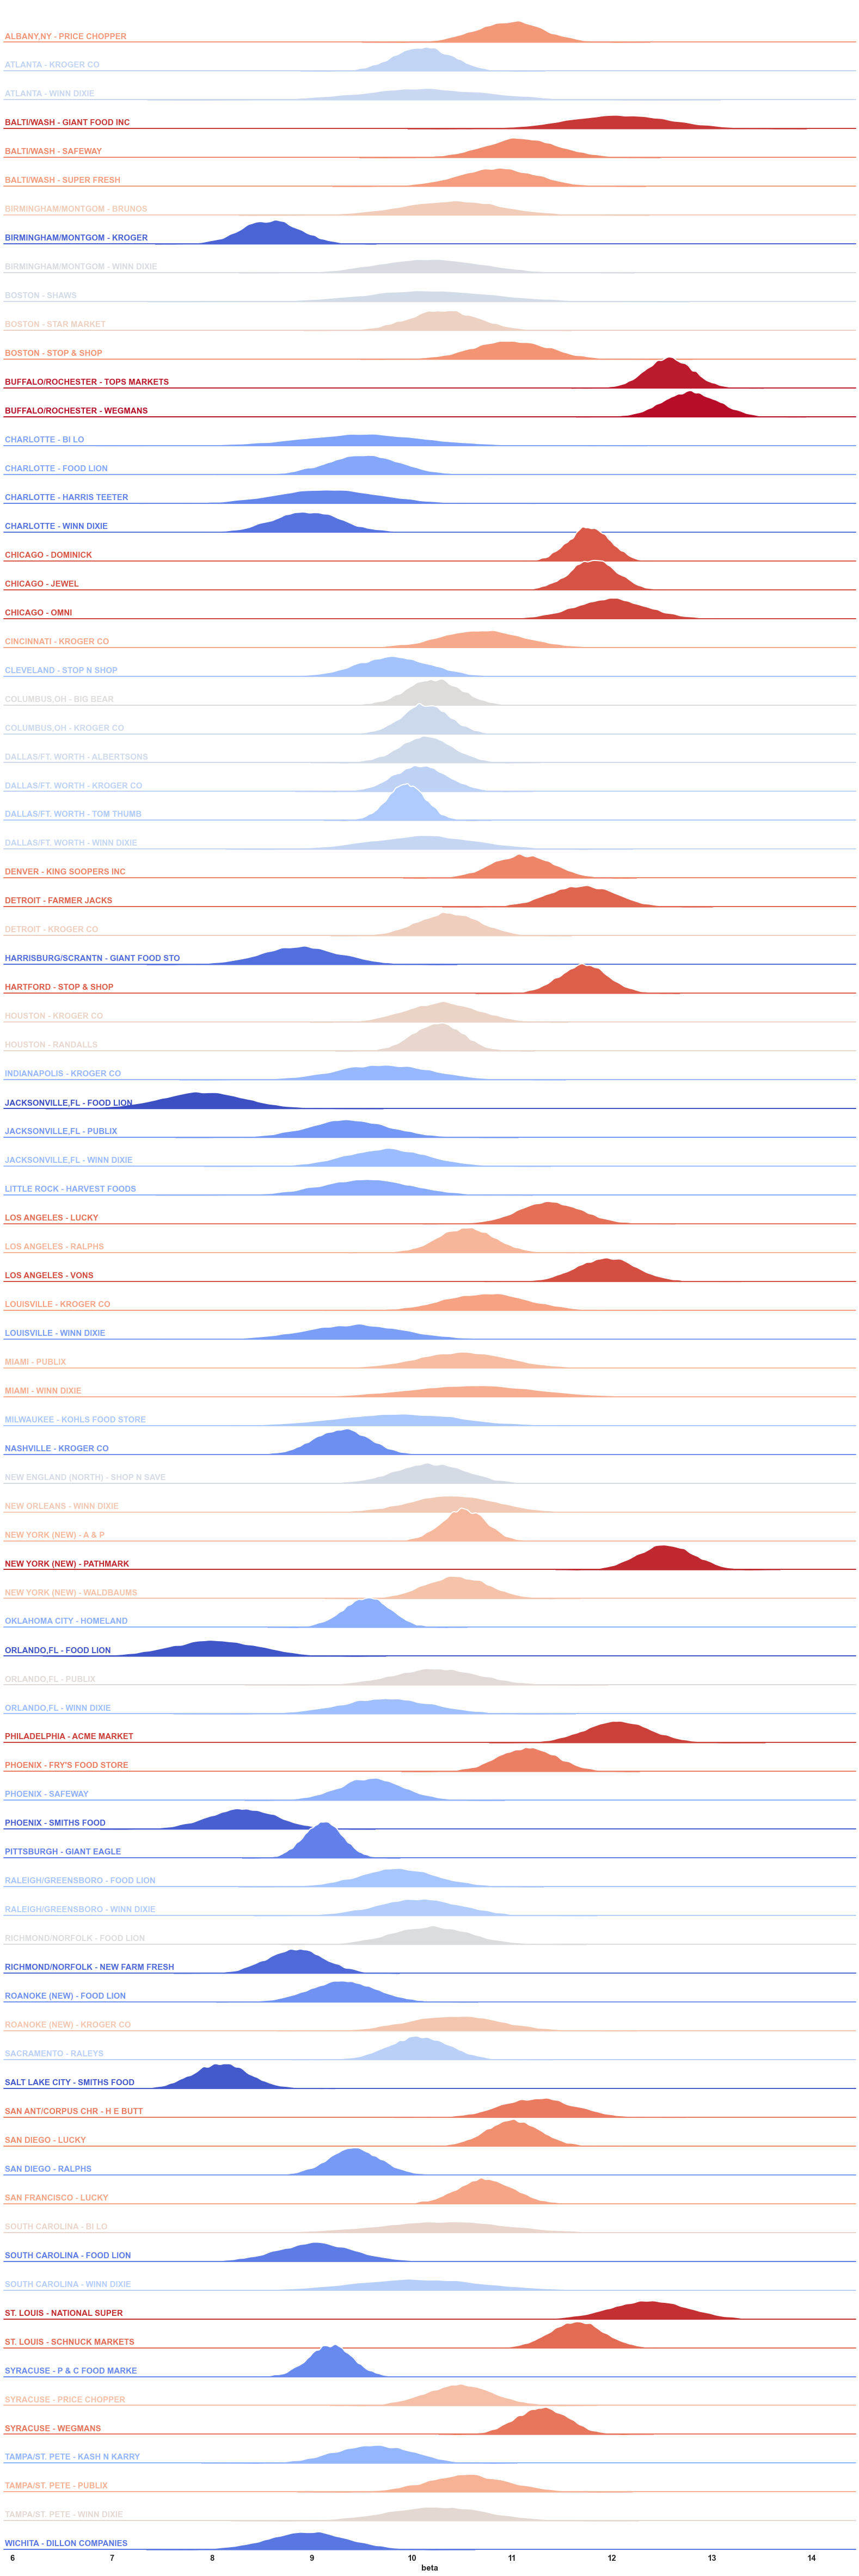

In [38]:
dfs = [pd.DataFrame(mod.traces['betas'][:,0,n]) for n in range(len(stores))]
for n in range(len(stores)):
    dfs[n]['store'] = stores[n]
    
df_new = pd.concat(dfs)
df_new.columns = ['values','store']   

mean_stores = df_new.groupby('store').mean().reset_index()
mean_stores.columns = ['store', 'mean']
df = pd.merge(df_new, mean_stores, how='inner',on='store')


import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data


# Initialize the FacetGrid object
pal = sns.color_palette(palette='coolwarm', n_colors=88)

g = sns.FacetGrid(df, row='store', hue='mean', aspect=30, height=0.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
#def label(x, color, label):
  #  ax = plt.gca()
  ##  ax.text(0, .2, label, fontweight="bold", color=color,
       #     ha="left", va="center", transform=ax.transAxes)


for i, ax in enumerate(g.axes.flat):
    ax.text(5.93, .2, stores[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    
g.fig.subplots_adjust(hspace=-0.25)
    
#g.map(label, "store")

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('beta', fontweight='bold', fontsize=15)
plt.savefig('beta_1_ridgeplot.png', dpi=200)